In [10]:
# Data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

# Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

# Pipeline library for efficient workflow
from sklearn.pipeline import Pipeline, make_pipeline

# Metrics libraries for evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, accuracy_score, confusion_matrix, precision_score
from sklearn import metrics

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Ignore warning messages
import warnings
warnings.simplefilter("ignore")

In [11]:
# Read in data locally
df = pd.read_csv('data/Tweets.csv', encoding='latin1')

# Read in data using google colab/drive
#df = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/tweets.csv', encoding='latin1')

In [12]:
numerical_features = list(df.select_dtypes("number"))
categorical_features = list(df.select_dtypes("object"))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Categorical Columns: \n{categorical_features}')

Numerical Columns: 
[]

Categorical Columns: 
['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


## EDA

In [13]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [15]:
df.nunique().sort_values(ascending=True)

is_there_an_emotion_directed_at_a_brand_or_product       4
emotion_in_tweet_is_directed_at                          9
tweet_text                                            9065
dtype: int64

In [16]:
df.isna().sum().sort_values(ascending=False)

emotion_in_tweet_is_directed_at                       5802
tweet_text                                               1
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [17]:
# Add ‘numeric_only=True’ param to avoid ‘could not convert string to float’ issue
df.corr(numeric_only=True)

""



## Data Cleaning

In [18]:
# Lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Renaming columns to better reflect the data
rename_cols = {
      'tweet_text': 'tweet',
      'emotion_in_tweet_is_directed_at': 'tweet_is_directed_at',
      'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
              }
df = df.rename(columns=rename_cols)


# rename values in the 'emotion' column
rename_values = {
      'no emotion toward brand or product': 'no emotion',
      'positive emotion': 'positive',
      'negative emotion': 'negative',
      "i can't tell": 'unsure'
              }
df['emotion'] = df['emotion'].map(rename_values)

# Dropping (1) single row from df['tweet_text']
df.dropna(subset=['tweet'], inplace=True)


# Filter out 17 tweets that contain both Apple & Google
apple_and_google = ~((df['tweet_is_directed_at'].isna()) &
                   (df['tweet'].str.contains('google')) &
                   (df['tweet'].str.contains('apple')))
df = df[apple_and_google]



## Create assert statements to confirm the code achieved its goals:

assert df.loc[(df['tweet_is_directed_at'].isna()) & (df['tweet'].str.contains('google')) & (df['tweet'].str.contains('apple')), 'tweet'].empty


## Feature Engineering

In [19]:
# Create column of with the character length of the tweet
df['character_count'] = df['tweet'].apply(len)


# Create column of with the word count of the tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))


# Creat column to determine if the tweet was negative toward a brand or not
df['is_tweet_negative'] = df['emotion'].apply(lambda x: 1 if x == 'negative' else 0 if x == 'positive' else 2)

# What company is the tweet about?
renamed_values = {
      'ipad': 1, 'ipad or iphone app': 1,
      'iphone': 1, 'other google product or service': 0,
      'android app': 0, 'android': 0, 'google': 0,
      'other apple product or service': 1, 'apple': 1,
                 }
df['is_apple'] = df['tweet_is_directed_at'].map(renamed_values).astype('Int64')


# Creating a feature call 'number_of_mentions' to count @mentions
df['number_of_mentions'] = df['tweet'].str.count('@\w+')


# Create a feature 'hashtags_count' to count hashtags
df['hashtags_count'] = df['tweet'].str.count('#')


# Create feature named 'average_word_length'
df['average_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Adding column to tell if data was generated by chatgpt data
df['chatgpt_data'] = 0


## Data Filtering

In [20]:
# Assigning unknown tweet to company based on 'apple_words'
apple_words = ['apple', 'iphone','ipod','ipad', 'i-pad', 'app store', 'itunes']
apple_regex = '|'.join(apple_words)  # creates the string 'apple|iphone|ipod|ipad|i-pad'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(apple_regex, case=False), 'is_apple'] = 1


# Assigning unknown tweet to company based on 'google_words'
google_words = ['google', 'android','pixel', 'google play']
google_regex = '|'.join(google_words)  # creates the string 'google|android|pixel|google play'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(google_regex, case=False), 'is_apple'] = 0


# Dropping tweets that have no mention of either Apple or Google
df.dropna(subset=['is_apple'], inplace=True)


# Drop the column 'tweet_is_directed_at' due to many missing values
#df = df.drop(columns=['tweet_is_directed_at'])

In [21]:
df['is_apple'].value_counts()

is_apple
1    5567
0    2802
Name: count, dtype: Int64

In [22]:
df['is_tweet_negative'].value_counts()

is_tweet_negative
2    4833
0    2967
1     569
Name: count, dtype: int64

## Import and Join Negative Tweet Data (via ChatGPT prompt engineering)

In [23]:
df['is_tweet_negative'].value_counts()

is_tweet_negative
2    4833
0    2967
1     569
Name: count, dtype: int64

In [24]:
# Read in data locally
neg_tweets = pd.read_csv('data/chatgpt_tweet_data.csv')

# Read in data using google colab/drive
#neg_tweets = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/chatgpt_tweet_data.csv')

# Lowercase
neg_tweets = neg_tweets.applymap(lambda s:s.lower() if type(s) == str else s)

# Adding column to tell if data was generated by chatgpt data
neg_tweets['chatgpt_data'] = 1

In [25]:
neg_tweets.head()

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,chatgpt_data
0,can't believe how slow the new iphone is!,apple,negative,37,8,1,1,0,0,4.6,1
1,google search results are so frustrating!,google,negative,37,6,1,0,0,0,6.2,1
2,the latest apple update crashed my device again!,apple,negative,45,9,1,1,0,0,4.8,1
3,i'm so disappointed with google's new feature.,google,negative,40,8,1,0,0,0,5.0,1
4,apple's customer service is a nightmare!,apple,negative,38,7,1,1,0,0,5.4,1


In [26]:
#Join Dataframes
df = pd.concat([df, neg_tweets], ignore_index=True)

In [27]:
df['is_tweet_negative'].value_counts()

is_tweet_negative
2    4833
0    2967
1    2920
Name: count, dtype: int64

## Modeling

In [28]:
# You might need to download these if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/llakes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/llakes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Function to preprocess tweets
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s@#]', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = tweet.split()
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    return tweet



In [30]:
# Apply preprocessing function to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess)

In [31]:
# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['is_tweet_negative']

In [32]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Print the original class distribution
print('Original class distribution: \n', y_train.value_counts())

Original class distribution: 
 is_tweet_negative
2    3867
0    2379
1    2330
Name: count, dtype: int64


In [34]:
# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.44      0.50       588
           1       0.93      0.81      0.87       590
           2       0.66      0.83      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7136194029850746


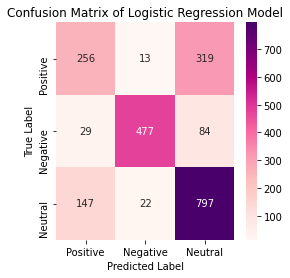

              precision    recall  f1-score   support

           0       0.59      0.44      0.50       588
           1       0.93      0.81      0.87       590
           2       0.66      0.83      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7136194029850746


In [88]:
# Generate confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap from the confusion matrix
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(matrix, annot=True, cmap='RdPu', fmt='d')

plt.title('Confusion Matrix of Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

labels = ['Positive', 'Negative', 'Neutral']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.show()

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

In [73]:
df.head()

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,chatgpt_data,processed_tweet
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,negative,127,23,1,1,1,2,4.521739,0,@wesley83 3g iphone 3 hr tweeting #rise_austin...
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,positive,139,22,0,1,2,1,5.363636,0,@jessedee know @fludapp awesome ipad iphone ap...
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,positive,79,15,0,1,1,2,4.333333,0,@swonderlin wait #ipad 2 also sale #sxsw
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,negative,82,15,1,1,1,1,4.533333,0,@sxsw hope year festival crashy year iphone ap...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,positive,131,17,0,0,1,1,6.764706,0,@sxtxstate great stuff fri #sxsw marissa mayer...


In [74]:
# Function to fit model and print classification report.
def model_tester(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    print(classification_report(y_test, model.predict(X_test)))

In [75]:
# Function to perform grid search and print classification report for best parameters.
def model_best_param_tester(model, params, X_train=X_train, y_train=y_train):
    gridsearch=GridSearchCV(model, param_grid=params)
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    return model_tester(gridsearch.best_estimator_)

In [76]:
#Initializing the models we will test out.
logreg=LogisticRegression()
bayes=MultinomialNB()
dtc=DecisionTreeClassifier()
rfc=RandomForestClassifier()
xg=xgb.XGBClassifier()

We will examine each model with its optimal parameters to see how it performs on our target metric, precision. 

In [77]:
model_best_param_tester(logreg, {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'newton-cg']})

{'C': 1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.59      0.44      0.50       588
           1       0.93      0.81      0.87       590
           2       0.66      0.83      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144



In [78]:
model_best_param_tester(bayes, {'fit_prior': [True, False], 'alpha': [0.001, 0.01, 0.1, 1]})

{'alpha': 1, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.61      0.36      0.45       588
           1       0.92      0.77      0.84       590
           2       0.64      0.86      0.73       966

    accuracy                           0.70      2144
   macro avg       0.72      0.67      0.68      2144
weighted avg       0.71      0.70      0.69      2144



In [79]:
model_best_param_tester(dtc, {'max_depth': [1,2,3,4,5], 'max_features': [1,2,3,4]})

{'max_depth': 2, 'max_features': 4}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       588
           1       0.62      0.03      0.06       590
           2       0.46      1.00      0.63       966

    accuracy                           0.46      2144
   macro avg       0.36      0.34      0.23      2144
weighted avg       0.38      0.46      0.30      2144



In [80]:
model_best_param_tester(rfc, {'n_estimators': [100, 150], 'max_features': [1,'sqrt', 'log2'], 'criterion': ['gini', 'entropy']})

{'criterion': 'gini', 'max_features': 1, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.62      0.40      0.49       588
           1       0.93      0.83      0.88       590
           2       0.66      0.84      0.74       966

    accuracy                           0.72      2144
   macro avg       0.74      0.69      0.70      2144
weighted avg       0.72      0.72      0.71      2144



In [81]:
model_best_param_tester(xg, {'booster': ['gbtree', 'gblinear' 'dart']})

{'booster': 'gbtree'}
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       588
           1       0.96      0.81      0.88       590
           2       0.66      0.86      0.74       966

    accuracy                           0.72      2144
   macro avg       0.74      0.69      0.70      2144
weighted avg       0.72      0.72      0.71      2144



The Gradient Boosting Classifier with default parameters has the best performance of all the models examined.